In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('../results/preds_resnet50_256.csv', index_col=0)

In [3]:
data.head()

,Celiac,EE,Normal,FileName
0,0.999989,4.067119e-08,0.000012,valid/Celiac/C12-64_01a___6000_4000___0_250_0.jpg
1,0.979840,5.339724e-07,0.020159,valid/Celiac/C16-77_02___4000_0___0_0_0.jpg
2,0.999990,1.476365e-07,0.000009,valid/Celiac/C10-47_02___16000_18040___500_0_0...
3,0.999185,1.615475e-08,0.000815,valid/Celiac/C16-77_01___4000_2000___500_0_0.jpg
4,0.621023,5.738719e-08,0.378977,valid/Celiac/C11-54_05___3000_2000___500_250_0...


In [4]:
np.sum((data['Celiac'] + data['EE'] + data['Normal']) > 1)

31833

In [5]:
tag = data['FileName'][0]

In [6]:
('_').join(tag.split('/')[2].split('_')[:len(tag.split('/')[2].split('_'))-3]).split('__')[0]

'C12-64_01a'

In [7]:
tags = tag.split('/')[2].split('_')

In [8]:
tags.remove(tag.split('/')[2].split('_')[-1])
tags.remove(tag.split('/')[2].split('_')[-2])
tags.remove(tag.split('/')[2].split('_')[-3])

In [9]:
a = '_'.join(tags)
a.split('__')[0]

'C12-64_01a'

In [10]:
# EE - 1
data['True'] = 1
data['Tag'] = None

In [11]:
df = data
df['Tag'] = df.FileName.apply(lambda x: ('_').join(x.split('/')[2].split('_')[:len(x.split('/')[2].split('_'))-3]).split('__')[0])

In [12]:
maskCeliac = (df['Tag'].str.startswith('C'))
df['True'] = df['True'].mask(maskCeliac, 0)

In [13]:
maskNormal = (df['Tag'].str.startswith('N'))
df['True'] = df['True'].mask(maskNormal, 2)

In [14]:
a = data.groupby('Tag')['Celiac', 'EE', 'Normal', 'True'].mean()

In [15]:
a = a.reset_index()
celiac = a[a['Tag'].str.startswith('C')]

In [16]:
normal = a[a['Tag'].str.startswith('N')]

In [17]:
normal['Score'] = normal['Normal']

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
celiac['Score'] = celiac['Celiac']

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
ee = a[pd.Series(a['Tag'].str.startswith('C') == False) & pd.Series(a['Tag'].str.startswith('N') == False)]

In [20]:
ee['Score'] = ee['EE']

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
a = pd.concat([celiac, ee, normal],ignore_index=True)

In [22]:
a['Pred'] = a[['Celiac', 'EE', 'Normal']].idxmax(axis=1)

In [23]:
a['Pred'] = a['Pred'].map({'Celiac': 0, 'EE': 1, 'Normal': 2})

In [24]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [25]:
y = a['True']
preds = a['Pred']

cnf_matrix = confusion_matrix(y, preds)
np.set_printoptions(precision=2)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.86 0.   0.14]
 [0.   1.   0.  ]
 [0.03 0.   0.97]]


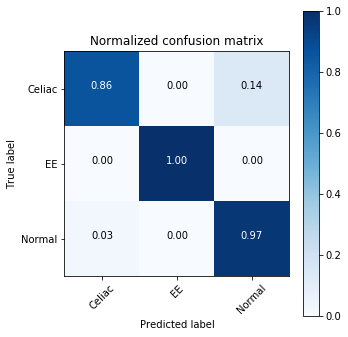

In [34]:
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cnf_matrix, classes=['Celiac', 'EE', 'Normal'],
                      title='Normalized confusion matrix', normalize=True)

plt.show()

In [88]:
from sklearn.metrics import classification_report

y_true = a['True']
y_pred = a['Pred']
target_names = ['Celiac', 'EE', 'Normal']
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

     Celiac       0.98      0.86      0.92        51
         EE       1.00      1.00      1.00        11
     Normal       0.83      0.97      0.90        36

avg / total       0.93      0.92      0.92        98



In [89]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

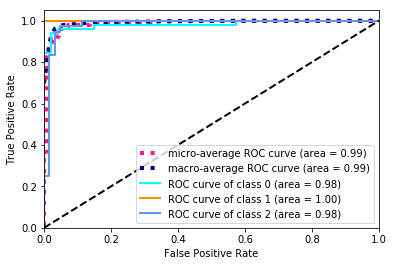

In [104]:
# Compute macro-average ROC curve and ROC area
n_classes = 3
y_test = label_binarize(y_true, classes=[0, 1, 2])
y_score = np.array(a[['Celiac', 'EE', 'Normal']])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
lw = 2
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('')
plt.legend(loc="lower right")
plt.show()

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

In [100]:
np.array(a[['Celiac', 'EE', 'Normal']])

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,